<a href="https://colab.research.google.com/github/Tinnapat1406/AI-Generator-Classification-/blob/main/AI_Generated_Image_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Import**

####**Library**

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import os
import cv2
from scipy.ndimage import gaussian_filter
import torch
import io
from io import BytesIO
from PIL import Image
from IPython.utils.openpy import BytesIO
import random
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models
from torch import nn
from torch.nn import functional as F

####**Import Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**API Dataset**

from : [https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images](https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images)

In [27]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)
ROOT = "/root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3"


Path to dataset files: /root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3


In [57]:
!ls $ROOT
!ls $ROOT/train
!ls $ROOT/test

test  train
FAKE  REAL
FAKE  REAL


In [37]:
!nvidia-smi

Wed Dec 31 07:53:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P0             28W /   70W |     836MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

###**Process**

In [2]:
def normalize(img):
  gray_image = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  normalized = cv2.normalize(
      gray_image,None,beta=255,norm_type=cv2.NORM_MINMAX)

  normalized_img = cv2.cvtColor(normalized,cv2.COLOR_GRAY2BGR)
  normalized_img = cv2.resize(normalized_img,(224,224))
  return normalized_img

In [3]:
def gaussion_gray(img,sigma) :
  if len(img.shape) == 3:
    img_blur = np.zeros_like(img)
    for i in range(img.shape[2]):
        img_blur[:,:,i] = gaussian_filter(img[:,:,i],sigma=sigma)

  else :
    img_blur = gaussian_filter(img,sigma=sigma)

  return img_blur


def gaussian_blur(img,sigma):
  gaussian_filter(
      img[:,:,0],
      output=img[:,:,0],
      sigma=sigma)
  gaussian_filter(
      img[:,:,1],
      output=img[:,:,1],
      sigma=sigma)
  gaussian_filter(
      img[:,:,1],
      output=img[:,:,2],
      sigma=sigma)


def gaussian_noise(img,mean,stddev,gamma =1):
  img = img.astype(np.float32)
  noise = np.random.normal(
      mean,
      stddev,
      img.shape).astype(np.float32)
  output = img + noise*gamma
  output = np.clip(output,0,255).astype(np.uint8)


  return noise,output


In [4]:
def cv2_encode(img,compress):
  img = img[:,:,::-1]
  encode = [int(cv2.IMWRITE_JPEG_QUALITY),compress]
  result,encimg = cv2.imencode('.jpg',img,encode)
  decimg = cv2.imdecode(encimg,1)
  return decimg[:,:,::-1]

def pil_img(img,compress):
  output = BytesIO()
  img = Image.fromarray(img)
  img.save(output,format= 'jpeg',quality = compress)
  img = Image.open(output)
  img = np.array(img)
  output.close()
  return img

jpeg_dict = {'cv2':cv2_encode,'pil':pil_img}

def jpeg_key(img,compress,key):
  method = jpeg_dict[key]
  return method(img,compress)


In [16]:
from types import SimpleNamespace

opt = SimpleNamespace(

    use_normalize = True,

    use_blur = False,
    blur_sig = [0.5,1,1.5],

    use_noise = False,
    noise_mean = 0,
    noise_std = [5,10],
    noise_gamma = 1,

    use_jpeg=True,
    jpg_qual=[70, 80, 90],
    jpg_method=['cv2', 'pil']

)


In [17]:
def preprocess(img,opt):
  if opt.use_normalize:
    img = normalize(img)
  else:
    img = cv2.imread(img)

  if opt.use_blur:
    sigma = random.choice(opt.blur_sig)
    img = gaussion_gray(img,sigma)

  if opt.use_noise:
    std = random.choice(opt.noise_std)
    _,img = gaussian_noise(
        img,
        opt.noise_mean,
        std,
        opt.noise_gamma
        )

  if opt.use_jpeg:
    qual = random.choice(opt.jpg_qual)
    method = random.choice(opt.jpg_method)
    img = jpeg_key(img,qual,method)

  return img

In [18]:
class GenDataset(Dataset):
    def __init__(self,root,split,opt):
      super().__init__()
      self.opt = opt
      self.image = []
      self.labels = []

      for label_name,label_val in [('REAL',1),('FAKE',0)]:
        img_dir = os.path.join(root,split,label_name)
        for f in os.listdir(img_dir):
          self.image.append(os.path.join(img_dir,f))
          self.labels.append(label_val)

    def __len__(self):
      return len(self.image)

    def __getitem__(self, idx):
      img = cv2.imread(self.image[idx])
      img = preprocess(img,self.opt)

      img = Image.fromarray(img)
      img =transforms.ToTensor()(img)
      label = torch.tensor(self.labels[idx],dtype=torch.float32)

      return img,label

###**Model**

In [8]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 220MB/s]


In [19]:
class SRMConv2d(nn.Module):
  def __init__(self, inc =3 ,learnable = False) :
    super(SRMConv2d,self).__init__()
    self.truc = nn.Hardtanh(-3,3)
    kernel = self._build_kernel(inc)
    self.kernel = nn.Parameter(data=kernel,requires_grad=learnable)


  def forward(self,x):
    out = F.conv2d(x,self.kernel,stride=1,padding=2)
    out = self.truc(out)
    return out

  def _build_kernel(self,inc):
    filter1 = torch.tensor([
            [0, 0, 0, 0, 0],
            [0, -1, 2, -1, 0],
            [0, 2, -4, 2, 0],
            [0, -1, 2, -1, 0],
            [0, 0, 0, 0, 0]
        ], dtype=torch.float32)

    filter2 = torch.tensor([
            [-1, 2, -2, 2, -1],
            [2, -6, 8, -6, 2],
            [-2, 8, -12, 8, -2],
            [2, -6, 8, -6, 2],
            [-1, 2, -2, 2, -1]
        ], dtype=torch.float32)

    filter3 = torch.tensor([
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 1, -2, 1, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0]
        ], dtype=torch.float32)

    filters = torch.stack([filter1, filter2, filter3])
    filters = filters / filters.abs().sum(dim=(1, 2), keepdim=True)
    filters = filters.unsqueeze(1)
    filters = filters.repeat(1, inc, 1, 1)

    return filters

In [20]:
class SRMResNet18(nn.Module):
  def __init__(self):
    super().__init__()
    self.srm = SRMConv2d(inc=3,learnable=True)

    self.backbone = models.resnet18(
        weights=models.ResNet18_Weights.IMAGENET1K_V1
    )

    self.backbone.fc = nn.Linear(
        self.backbone.fc.in_features,1
    )

  def forward(self,x):
    x = self.srm(x)
    x = self.backbone(x)
    return x


###**Train**

In [29]:
train_dataset = GenDataset(ROOT, "train", opt)

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0,
    pin_memory=False,

)

In [31]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
    )

model = SRMResNet18().to(device)
model.train()

SRMResNet18(
  (srm): SRMConv2d(
    (truc): Hardtanh(min_val=-3, max_val=3)
  )
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     

In [32]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr = 1e-4,
    weight_decay=1e-4
    )

In [60]:
images,labels = next(iter(train_loader))
images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
  logits = model(images)

print(logits.shape)
print(labels.shape)

torch.Size([16, 1])
torch.Size([16])


In [38]:
for p in model.backbone.parameters():
    p.requires_grad = False

for p in model.backbone.fc.parameters():
    p.requires_grad = True

In [58]:
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)

In [43]:
for epoch in range(10):
    model.train()
    running_loss = 0

    for step, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images).squeeze(1)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if step % 500 == 0:
            print(f"Epoch {epoch}, Step {step}: loss = {loss.item():.4f}")

    print(f"Epoch {epoch}: Average loss = {running_loss / len(train_loader):.4f}")

Epoch 0, Step 0: loss = 0.5401
Epoch 0, Step 500: loss = 0.2203
Epoch 0, Step 1000: loss = 0.5637
Epoch 0, Step 1500: loss = 0.2572
Epoch 0, Step 2000: loss = 0.2741
Epoch 0, Step 2500: loss = 0.2213
Epoch 0, Step 3000: loss = 0.4782
Epoch 0, Step 3500: loss = 0.2107
Epoch 0, Step 4000: loss = 0.1746
Epoch 0, Step 4500: loss = 0.2945
Epoch 0, Step 5000: loss = 0.3430
Epoch 0, Step 5500: loss = 0.7448
Epoch 0, Step 6000: loss = 0.3062
Epoch 0: Average loss = 0.3441
Epoch 1, Step 0: loss = 0.2698
Epoch 1, Step 500: loss = 0.7210
Epoch 1, Step 1000: loss = 0.4933
Epoch 1, Step 1500: loss = 0.3684
Epoch 1, Step 2000: loss = 0.2427
Epoch 1, Step 2500: loss = 0.7761
Epoch 1, Step 3000: loss = 0.5688
Epoch 1, Step 3500: loss = 0.4798
Epoch 1, Step 4000: loss = 0.2343
Epoch 1, Step 4500: loss = 0.3724
Epoch 1, Step 5000: loss = 0.2790
Epoch 1, Step 5500: loss = 0.4147
Epoch 1, Step 6000: loss = 0.3483
Epoch 1: Average loss = 0.3407
Epoch 2, Step 0: loss = 0.4108
Epoch 2, Step 500: loss = 0.350

###**Test**

In [49]:
test_opt = SimpleNamespace(
    use_normalize=True,

    use_blur=False,
    blur_sig=None,

    use_noise=False,
    noise_mean=0,
    noise_std=None,
    noise_gamma=1,

    use_jpeg=False,
    jpg_qual=None,
    jpg_method=None
)

In [47]:
test_dataset = GenDataset(
    root=ROOT,
    split="test",
    opt=opt
)

print("Test samples:", len(test_dataset))

Test samples: 20000


In [50]:
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [52]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()
test_loss = 0
all_predicted = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        logits = model(inputs).squeeze(1)
        loss = criterion(logits, labels)

        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        test_loss += loss.item()
        all_predicted.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)

all_labels = np.array(all_labels)
all_predicted = np.array(all_predicted)

accuracy = accuracy_score(all_labels, all_predicted)
precision = precision_score(all_labels, all_predicted)
recall = recall_score(all_labels, all_predicted)
f1 = f1_score(all_labels, all_predicted)

print(f"Average Test Loss: {avg_test_loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Average Test Loss: 0.3215
Accuracy: 86.37%
Precision: 0.9129
Recall: 0.8041
F1 Score: 0.8551


###**Summary**

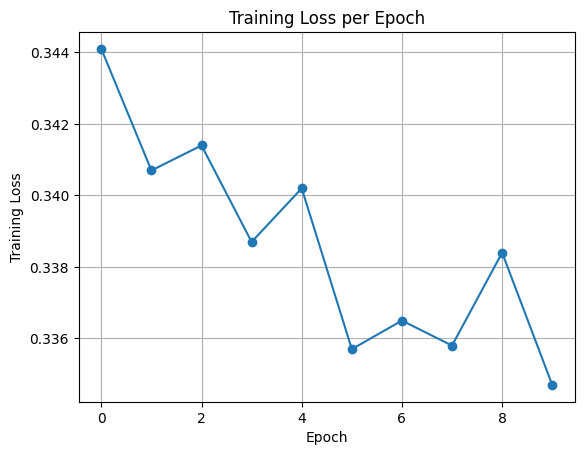

In [54]:
import matplotlib.pyplot as plt

train_losses = [
    0.3441,
    0.3407,
    0.3414,
    0.3387,
    0.3402,
    0.3357,
    0.3365,
    0.3358,
    0.3384,
    0.3347
]
epochs = range(len(train_losses))

plt.figure()
plt.plot(epochs, train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss per Epoch")
plt.grid(True)
plt.show()


<Figure size 640x480 with 0 Axes>

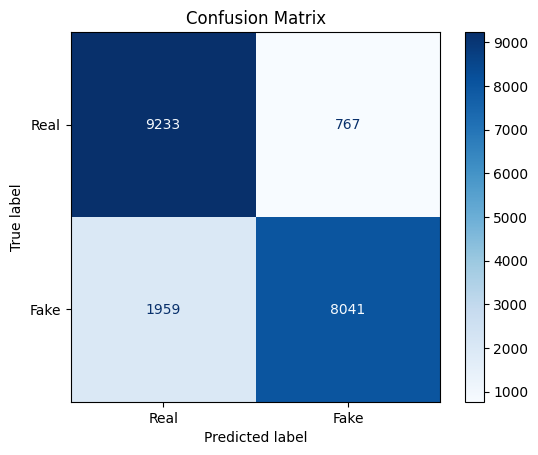

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_predicted)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Real", "Fake"]
)

plt.figure()
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()